# TimeSHAP

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import mat4py as mpy
import os
# model from jason
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt

In [2]:
file_path = '/Users/sigurdgjerdingen/Student/Master kode/Master_Herstad-Gjerdingen/Aachen/Degradation_Prediction_Dataset_ISEA.mat'
test_cell_count = 3
random_state = 42

# Load and transform data
data_loader = mpy.loadmat(file_path)
df = pd.DataFrame.from_dict(data_loader["TDS"])

def compute_eol_and_rul80(row):
    history_cap = np.array(row["History"])
    history_cycles = np.array(row["History_Cycle"])
    target_cap = np.array(row["Target_expanded"])
    target_cycles = np.array(row["Target_Cycle_Expanded"])

    if len(history_cap) == 0 or len(history_cycles) == 0:
        return pd.Series({"EOL80": np.nan, "RUL80": np.nan})

    threshold = 0.8 * history_cap[0]

    if history_cap[-1] <= threshold or len(target_cap) == 0 or len(target_cycles) == 0:
        return pd.Series({"EOL80": np.nan, "RUL80": np.nan})

    below_threshold_indices = np.where(target_cap < threshold)[0]
    if len(below_threshold_indices) > 0:
        eol80_cycle = target_cycles[below_threshold_indices[0]]
        rul80 = eol80_cycle - history_cycles[-1]
        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

    return pd.Series({"EOL80": np.nan, "RUL80": np.nan})

df[["EOL80", "RUL80"]] = df.apply(compute_eol_and_rul80, axis=1)
df_valid = df[df["RUL80"].notna()]

# Hold back specific cells for testing
cells_to_hold_back = df_valid["Cell"].unique()[:test_cell_count]
df_test = df_valid[df_valid["Cell"].isin(cells_to_hold_back)]
df_train_val = df_valid[~df_valid["Cell"].isin(cells_to_hold_back)]

# Split into training and validation sets
df_train, df_val = train_test_split(
    df_train_val,
    test_size=0.2,
    random_state=random_state,
    stratify=df_train_val["Cell"]
)

# Extract sequences and target RUL80
history_train = df_train["History"].tolist()
history_val = df_val["History"].tolist()
history_test = df_test["History"].tolist()

y_train = np.array(df_train["RUL80"])
y_val = np.array(df_val["RUL80"])
y_test = np.array(df_test["RUL80"])

# Normalize historical capacity sequences
all_histories = history_train + history_val + history_test
all_histories_flat = np.concatenate(all_histories)
scaler = MinMaxScaler()
scaler.fit(all_histories_flat.reshape(-1, 1))

history_train_normalized = [scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in history_train]
history_val_normalized = [scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in history_val]
history_test_normalized = [scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in history_test]

# Normalize target values
y_max = y_train.max()
y_train_norm = y_train / y_max
y_val_norm = y_val / y_max
y_test_norm = y_test / y_max

# Pad sequences
max_sequence_length = max(len(h) for h in all_histories)
X_train_padded = pad_sequences(history_train_normalized, maxlen=max_sequence_length, padding='post', dtype='float32')
X_val_padded = pad_sequences(history_val_normalized, maxlen=max_sequence_length, padding='post', dtype='float32')
X_test_padded = pad_sequences(history_test_normalized, maxlen=max_sequence_length, padding='post', dtype='float32')

# Reshape for LSTM input
X_train_lstm = X_train_padded[..., np.newaxis]
X_val_lstm = X_val_padded[..., np.newaxis]
X_test_lstm = X_test_padded[..., np.newaxis]

In [3]:
y_train_norm

array([0.18650794, 0.58730159, 0.48809524, ..., 0.49603175, 0.00396825,
       0.72619048])

In [4]:
def load_model_structure_and_weights(model_name, directory="Aachen/Models"):
    """Load a model structure and weights."""
    # Ensure model_name includes the directory
    if not os.path.dirname(model_name):  # If no directory in model_name
        model_name = os.path.join(directory, model_name)

    # Load model structure and weights paths
    structure_file = f"{model_name}.structure.json"
    weights_file = f"{model_name}.weights.h5"

    # Print the paths being checked
    print("Checking for model files in the following paths:")
    print(f"Structure file: {structure_file}")
    print(f"Weights file: {weights_file}")

    # Print the contents of the directory
    directory = os.path.dirname(structure_file)
    print(f"Contents of directory '{directory}':")
    print(os.listdir(directory) if os.path.exists(directory) else "Directory does not exist.")

    # Check if files exist
    if not os.path.exists(structure_file) or not os.path.exists(weights_file):
        raise FileNotFoundError("Model structure or weights file not found.")

    # Load model structure
    with open(structure_file, "r") as json_file:
        model = model_from_json(json_file.read())

    # Load model weights
    model.load_weights(weights_file)
    print(f"Model loaded from {structure_file} and {weights_file}")
    return model

model = load_model_structure_and_weights('model_20250131_123220')

model

Checking for model files in the following paths:
Structure file: Aachen/Models/model_20250131_123220.structure.json
Weights file: Aachen/Models/model_20250131_123220.weights.h5
Contents of directory 'Aachen/Models':
['model_20250127_135003.structure.json', 'model_20250131_124416.weights.h5', 'model_20250127_135003.weights.h5', 'model_20250128_130021.structure.json', 'model_20250128_130021.weights.h5', 'model_20250131_123220.structure.json', 'model_20250131_124416.structure.json', 'model_20250131_123220.weights.h5']
Model loaded from Aachen/Models/model_20250131_123220.structure.json and Aachen/Models/model_20250131_123220.weights.h5


<Sequential name=sequential_1, built=True>

In [5]:
def plot_predictions_vs_actual(y_test, y_pred):
    """Scatterplot comparing actual vs. predicted values."""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
    plt.title("Predicted vs Actual RUL80")
    plt.xlabel("Actual RUL80")
    plt.ylabel("Predicted RUL80")
    plt.legend()
    plt.grid()
    plt.show()


def plot_residuals(y_test, y_pred):
    """Plot residuals (difference between actual and predicted values)."""
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title("Residuals Histogram")
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5791e-04 - mae: 0.0192

Test Loss: 0.0011460963869467378
Test MAE: 0.027306677773594856
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
   Actual RUL80  Predicted RUL80
0        1060.0      1031.006592
1        1055.0      1031.462646
2        1050.0      1029.203613
3        1045.0      1024.487549
4        1040.0      1017.905579


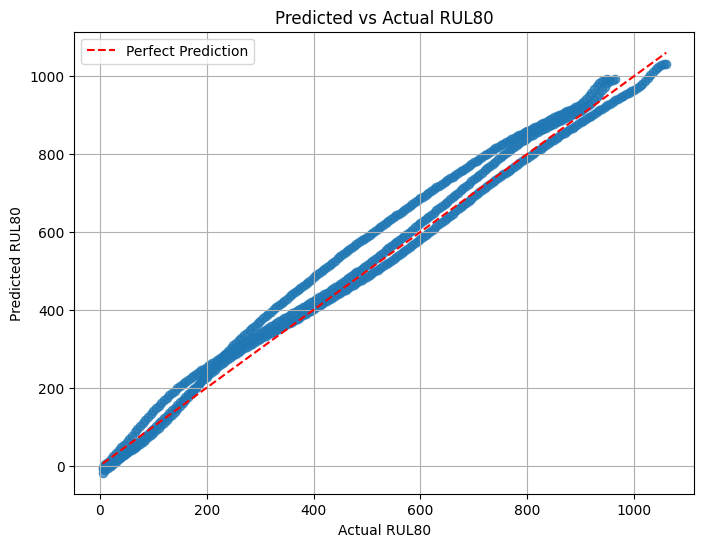

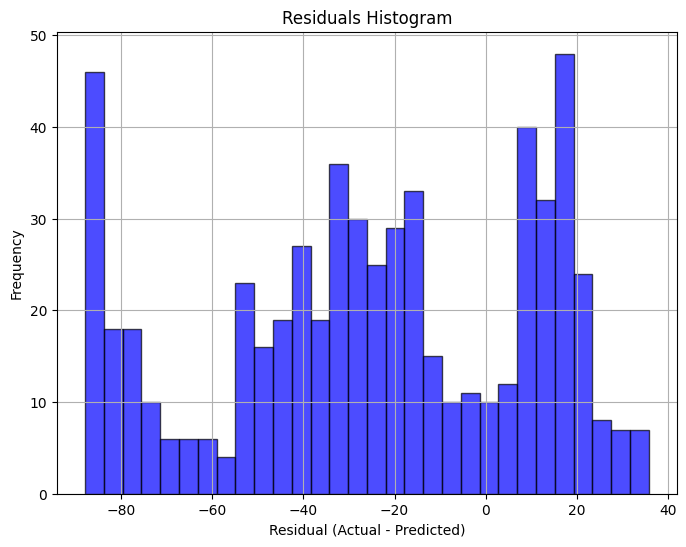

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 272, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48)             │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         1,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,805 (135.96 KB)

 Trainable params: 11,601 (45.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,204 (90.64 KB)

None


In [6]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_lstm, y_test_norm, verbose=1)
print(f"\nTest Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Rescale predictions and test data back to the original range
y_pred_rescaled = y_pred.flatten() * y_max
y_test_rescaled = y_test_norm * y_max

# Compare actual and predicted values
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_rescaled
})
print(results.head())

# Plot predictions vs actual
plot_predictions_vs_actual(y_test_rescaled, y_pred_rescaled)

# Plot residuals
plot_residuals(y_test_rescaled, y_pred_rescaled)


print(model.summary())

## TimeSHAP

### Model entry point

In [7]:
f = lambda x: model.predict(x)

### Baseline event

In [8]:
def avg_rul(X_train_lstm):
    # Reshape the array to 2D for easier processing
    X_train_lstm_2d = X_train_lstm.reshape(-1, X_train_lstm.shape[-1])
    
    # Create a mask to exclude rows that are all zeros
    non_zero_mask = np.any(X_train_lstm_2d != 0, axis=1)
    
    # Calculate the mean of the non-zero rows
    avg = np.mean(X_train_lstm_2d[non_zero_mask])
    
    # Return the average as a NumPy array with shape (1, 1)
    return np.array([[avg]])

average_event = avg_rul(X_train_lstm)

average_event

array([[0.6730101]], dtype=float32)

In [6]:
from timeshap.utils import get_avg_score_with_avg_event
avg_score_over_len = get_avg_score_with_avg_event(f, average_event, top=272)

avg_score_over_len

/opt/miniconda3/envs/timeshap_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

{1: 0.494919,
 2: 0.586053,
 3: 0.679238,
 4: 0.760838,
 5: 0.819555,
 6: 0.848629,
 7: 0.847165,
 8: 0.819791,
 9: 0.774717,
 10: 0.721112,
 11: 0.667003,
 12: 0.618259,
 13: 0.578548,
 14: 0.549757,
 15: 0.532472,
 16: 0.52634,
 17: 0.530294,
 18: 0.54268,
 19: 0.561374,
 20: 0.583919,
 21: 0.607716,
 22: 0.630261,
 23: 0.649407,
 24: 0.66359,
 25: 0.671981,
 26: 0.674518,
 27: 0.671819,
 28: 0.665001,
 29: 0.655454,
 30: 0.644621,
 31: 0.633821,
 32: 0.624132,
 33: 0.616328,
 34: 0.610868,
 35: 0.607913,
 36: 0.607364,
 37: 0.608911,
 38: 0.612093,
 39: 0.616361,
 40: 0.621136,
 41: 0.625871,
 42: 0.630098,
 43: 0.633466,
 44: 0.635763,
 45: 0.636916,
 46: 0.636982,
 47: 0.636119,
 48: 0.634559,
 49: 0.632565,
 50: 0.630406,
 51: 0.628325,
 52: 0.626516,
 53: 0.625118,
 54: 0.624207,
 55: 0.623799,
 56: 0.623859,
 57: 0.624308,
 58: 0.625045,
 59: 0.625952,
 60: 0.626912,
 61: 0.627823,
 62: 0.6286,
 63: 0.629187,
 64: 0.629552,
 65: 0.629693,
 66: 0.629629,
 67: 0.629399,
 68: 0.62

### Local explanations

#### Sequence to explain

In [39]:
# Select a random sequence from the test set

random_index = np.random.randint(0, len(X_test_lstm))
random_sequence = X_test_lstm[random_index][np.newaxis, ...]

# Number of 0 in random sequence
n_zeros = np.sum(random_sequence == 0)
n_zeros

63

#### Local report 

In [25]:
from timeshap.explainer import local_report

#pruning_dict = {'tol': 0.025}
pruning_dict = None
event_dict = {'rs': 42, 'nsamples': 32000}
feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': None, 'plot_features': None}
cell_dict = {'rs': 42, 'nsamples': 32000, 'top_x_feats': 1, 'top_x_events': 5}
local_report(f, random_sequence, pruning_dict, event_dict, feature_dict, cell_dict=cell_dict, baseline=average_event)

Assuming all features are model features
No pruning dict passed. Skipping pruning procedures
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.HConcatChart(...)

### Global explanations

#### Global report

In [20]:
# Sampel out 5 random sequences from the test set
random_indices = np.random.choice(len(X_test_lstm), 5)
random_sequences = X_test_lstm[random_indices]

In [21]:
from timeshap.explainer import global_report

model_feature = ["rul"]
schema = ["rul"]
plot_featrues = {"rul": "RUL"}

pruning_dict = {'tol': [0.05, 0.075], 'path': 'outputs/prun_all_tf.csv'}
event_dict = {'path': 'outputs/event_all_tf.csv', 'rs': 42, 'nsamples': 32000}
feature_dict = {'path': 'outputs/feature_all_tf.csv', 'rs': 42, 'nsamples': 32000, 'feature_names': None, 'plot_features': None,}

prun_stats, global_plot = global_report(
    f,                     # your model callable
    random_sequences,      # your NumPy array data
    pruning_dict,
    event_dict,
    feature_dict,
    average_event,              # baseline computed above
    model_features=None,        # provided as a list ["price"]
    schema=None,                # provided schema, also ["price"]
    entity_col=None,       # not applicable for NumPy array input
    time_col=None,         # not applicable here
    append_to_files=False,
    max_instances=1000,
    verbose=True
)

prun_stats

Assuming all features are model features
Calculating pruning algorithm
No time col provided, assuming dataset is ordered ascendingly by date
Allowed importance for pruned events: None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
len 0 | importance -0.21374210715293884
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
len -1 | importance -0.1769006997346878
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
len -2 | importance -0.1309422105550766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
len -3 | importance -0.08286528289318085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
len -4 | importance -0.03975008428096771
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━

KeyboardInterrupt: 

In [ ]:
global_plot

### Individual Plots

#### Local Plots

In [26]:
from timeshap.explainer import local_pruning
from timeshap.plot import plot_temp_coalition_pruning

pruning_dict = {'tol': 0,}
coal_plot_data, coal_prun_idx = local_pruning(f, random_sequence, pruning_dict, average_event)
# coal_prun_idx is in negative terms
pruning_idx = random_sequence.shape[1] + coal_prun_idx

pruning_plot = plot_temp_coalition_pruning(coal_plot_data, coal_prun_idx, plot_limit=280)
pruning_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [27]:
from timeshap.explainer import local_event
from timeshap.plot import plot_event_heatmap
pruning_idx = 0

event_dict = {'rs': 42, 'nsamples': 32000}
event_data = local_event(f, random_sequence, event_dict, entity_uuid=None, entity_col=None, baseline=average_event, pruned_idx=pruning_idx)
event_plot = plot_event_heatmap(event_data)
event_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [28]:
from timeshap.explainer import local_feat
from timeshap.plot import plot_feat_barplot

feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': None, 'plot_features': None}
feature_data = local_feat(f, 
                          random_sequence, 
                          feature_dict,
                          entity_uuid=None, 
                          entity_col=None,
                          baseline=average_event, 
                          pruned_idx=pruning_idx)

feature_plot = plot_feat_barplot(feature_data, feature_dict.get('top_feats'), feature_dict.get('plot_features'))
feature_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [30]:
from timeshap.explainer import local_cell_level
from timeshap.plot import plot_cell_level

cell_dict = {'rs': 42, 'nsamples': 32000, 'top_x_events': 5, 'top_x_feats': 1}
cell_data = local_cell_level(f, random_sequence, cell_dict, event_data, feature_data, entity_uuid=None, entity_col=None, baseline=average_event, pruned_idx=pruning_idx)
feat_names = list(feature_data['Feature'].values)[:-1] # exclude pruned events
cell_plot = plot_cell_level(cell_data, feat_names, feature_dict.get('plot_features'))
cell_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [2]:
# Add sequence IDs (if 'Cell' exists, we can use that)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Create DataFrames from the NumPy arrays
def create_dataframe(X, y, original_df, dataset_type):
    data_list = []
    for i in range(len(X)):
        sequence = X[i].flatten()  # Flatten the sequence for DataFrame representation
        sequence_length = np.count_nonzero(sequence)  # Actual non-padded sequence length
        cell_id = original_df.iloc[i]["Cell"] if "Cell" in original_df.columns else f"{dataset_type}_{i}"
        
        data_list.append({
            'sequence_id': cell_id,
            'sequence_length': sequence_length,
            'sequence': sequence,
            'RUL_normalized': y[i]
        })
    
    return pd.DataFrame(data_list)

# Create DataFrames
df_train_final = create_dataframe(X_train_lstm, y_train_norm, df_train, 'train')
df_val_final = create_dataframe(X_val_lstm, y_val_norm, df_val, 'val')
df_test_final = create_dataframe(X_test_lstm, y_test_norm, df_test, 'test')


NameError: name 'df_train' is not defined

In [1]:
import Cell_level

/opt/miniconda3/envs/timeshap_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:


# Create dummy event-level explanation DataFrame.
# It must include columns: 'index', 'Feature', 'Shapley Value'.
event_data = pd.DataFrame({
    'index': list(range(seq_len)),
    'Feature': [f'Event {i}' for i in range(seq_len)],
    'Shapley Value': np.random.randn(seq_len)  # random Shapley values for illustration
})

# Set up a minimal cell_dict configuration.
# Since there's only one feature, we only care about selecting events.
cell_dict = {
    'threshold': 0.1,   # Only events with abs(Shapley Value) >= 0.1 will be considered.
    'rs': 42,           # Random seed for reproducibility.
    'nsamples': 100,    # Number of samples for the kernel estimation.
    'path': None        # No path provided so that the explanation is calculated afresh.
}

# For a single-feature scenario, pruned_idx can be 0 (or an appropriate index if pruning is applied).
pruned_idx = 0

# entity_uuid and entity_col are not used in this bare-bones example.
entity_uuid = None
entity_col = None

# Call the function to compute the single-feature cell-level explanation.
cell_explanation = local_cell_level_single_feature(
    f=dummy_model,
    data=data,
    cell_dict=cell_dict,
    event_data=event_data,
    entity_uuid=entity_uuid,
    entity_col=entity_col,
    baseline=baseline,
    pruned_idx=pruned_idx
)

print("Cell-level Explanation (Single Feature):")
print(cell_explanation)

In [28]:
from typing import Callable, Union
import numpy as np
import pandas as pd
from timeshap.explainer.kernel import TimeShapKernel

def local_event_level_single_feature_standalone(
    f: Callable[[np.ndarray], np.ndarray],
    data: Union[pd.DataFrame, np.ndarray],
    event_dict: dict,
    baseline: Union[pd.DataFrame, np.ndarray],
    pruned_idx: int
) -> pd.DataFrame:
    """
    Computes event-level (cell-level) explanations for a single-feature model using
    the easier-to-use event mode of TimeShapKernel.
    
    Each time step (after the pruned index) is treated as an event.
    
    Parameters
    ----------
    f : Callable[[np.ndarray], np.ndarray]
        Model function that accepts a 3-D numpy array of shape (1, seq_len, 1)
        and returns a 2-D numpy array.
    data : Union[pd.DataFrame, np.ndarray]
        Input instance to be explained. If a DataFrame, it will be converted to a
        3-D numpy array.
    event_dict : dict
        Dictionary with parameters for the event explanation. Expected keys include:
          - 'rs': random seed (default: 42)
          - 'nsamples': number of samples for the kernel estimation (default: 100)
    baseline : Union[pd.DataFrame, np.ndarray]
        Baseline data (e.g. an average event) used for integrating out features.
    pruned_idx : int
        The index at which the sequence is pruned (e.g. 0 if no pruning is applied).
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with columns ['Event', 'Shapley Value'] listing the explanation
        for each event (time step).
    """
    # Convert DataFrame to numpy array if needed.
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
        # If 2-D, expand to 3-D (1, seq_len, num_features)
        if len(data.shape) == 2:
            data = np.expand_dims(data, axis=0)
        # Ensure that the last dimension is 1 (since we have one feature)
        if data.shape[-1] != 1:
            data = data[..., np.newaxis]
    
    # Extract parameters for the explainer from event_dict.
    random_seed = event_dict.get('rs', 42)
    nsamples = event_dict.get('nsamples', 100)
    
    # Instantiate the TimeShapKernel in event mode.
    # In event mode, the kernel automatically uses all time steps (after pruned_idx)
    # as the events to be explained.
    explainer = TimeShapKernel(f, baseline, random_seed, mode="event")
    
    # Compute Shapley values for the instance.
    # The output is an array of one value per event.
    shap_values_arr = explainer.shap_values(data, pruning_idx=pruned_idx, nsamples=nsamples)
    
    # In event mode, internally the explainer computes:
    #     self.varyingInds = np.arange(data.shape[1]-1, pruned_idx-1, -1)
    # so that the first computed value corresponds to the last time step.
    # To list events in natural order (from first event to last), we reverse the array.
    shap_values_arr_reversed = shap_values_arr[::-1]
    
    # Create labels for events.
    # Events correspond to the time steps starting at pruned_idx up to the end of the sequence.
    events = [f"Event {i}" for i in range(pruned_idx, data.shape[1])]
    
    # Build the explanation DataFrame.
    explanation_df = pd.DataFrame({
        "Event": events,
        "Shapley Value": shap_values_arr_reversed
    })
    
    return explanation_df


# Example usage:
if __name__ == "__main__":
   # Minimal event configuration.
    event_dict = {
        'rs': 42,          # Random seed.
        'nsamples': 10000    # Number of samples for the kernel estimation.
    }
    
    pruned_idx = 0  # No pruning in this simple example.
    
    # Get the event-level explanation.
    event_explanation = local_event_level_single_feature_standalone(
        f=f,
        data=random_sequence,
        event_dict=event_dict,
        baseline=average_event,
        pruned_idx=pruned_idx
    )
    
    print("Standalone Event-level Explanation (Single Feature):")
    print(event_explanation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Standalone Event-level Explanation (Single Feature):
         Event  Shapley Value
0      Event 0       0.000000
1      Event 1       0.000000
2      Event 2       0.000000
3      Event 3       0.000671
4      Event 4       0.000000
..         ...            ...
267  Event 267       0.000572
268  Event 268       0.000000
269  Event 269       0.000000
270  Event 270       0.000000
271  Event 271       0.001026

[272 rows x 2 columns]


In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Extract numeric event number from the Event column
event_explanation['Event Number'] = event_explanation['Event'].str.extract(r'Event (\d+)').astype(int)


sequence_line = random_sequence.flatten()

# --- Create Dual Y-axis Plot ---
# Create a subplot with secondary y-axis enabled.
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add the Shapley Value trace on the primary y-axis.
fig.add_trace(
    go.Scatter(
        x=event_explanation["Event Number"],
        y=event_explanation["Shapley Value"],
        mode='lines',
        name='Shapley Value'
    ),
    secondary_y=False
)

# Add the sequence values trace on the secondary y-axis.
fig.add_trace(
    go.Scatter(
        x=event_explanation["Event Number"],
        y=sequence_line,
        mode='lines',
        name='Sequence Values'
    ),
    secondary_y=True
)

# Update layout and y-axes titles.
fig.update_layout(
    title="Event-level Explanation with Dual Y-Axis",
    xaxis_title="Event Number"
)
fig.update_yaxes(title_text="Shapley Value", secondary_y=False)
fig.update_yaxes(title_text="Sequence Value", secondary_y=True)

fig.show()

In [30]:
# Make predictions on the test set
y_pred = model.predict(random_sequence)

# Rescale predictions and test data back to the original range
y_pred_rescaled = y_pred.flatten() * y_max

y_pred_rescaled

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([872.8788], dtype=float32)